# 01_run_simulations


## Imports, define model

In [1]:
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size']=16
import numpy as np
from matplotlib.colors import LogNorm
import csv

from scipy.optimize import curve_fit
import scipy.special as special
from scipy import integrate

path = os.getcwd()
basepath = os.path.dirname(path)
datapath = basepath+'/data'
figpath = basepath+'/figures'
srcpath =  basepath +'/src'

if srcpath not in sys.path:
    sys.path.append(srcpath)

import models
from pdeSim import PoissonFlow2D    

half_width = 5
glass = True

#Save details
save_file = True
save_name = 'glass_'+ str(glass)
print(save_name)

#Import the model
k_in,c_in,rho_in,Q_in,v_in,x,y,dx,dy,nx,ny = models.single_wire(glass=glass,half_width=half_width)

#Use microns as units for plotting
x = x*1e6
y = y*1e6

glass_True


In [2]:
##Builds up the dictionaries of thermal parameters

k = {}
c = {}
rho = {}

filename = basepath+"/src/thermal_properties.csv"

with open(filename,'r') as f:
    csvreader = csv.DictReader(f)
    for row in csvreader:
        k[row['material']]= float(row['thermal_conductivity'])
        c[row['material']]= float(row['specific_heat'])
        rho[row['material']]= float(row['density'])

## Plot heat sources/sinks

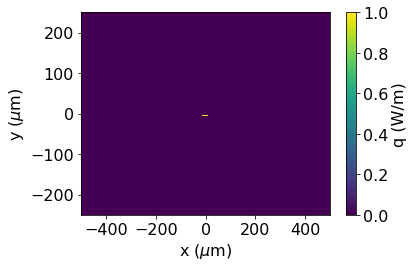

In [3]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.pcolor(x,y,Q_in.T,shading='auto')
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('q (W/m)')
fig.tight_layout()

if save_file==True:
    fig.savefig(figpath+ '/'+save_name+'_q.png',dpi=300)

## Plot thermal conductivities

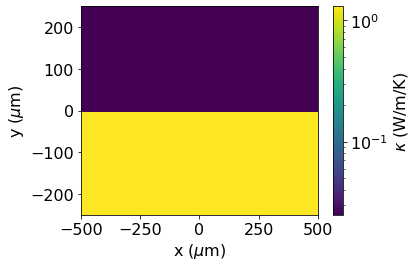

In [4]:
fig,ax=plt.subplots(1,1,figsize=[6,4])

myplot = ax.pcolor(x[::1],y[::1],k_in.T[::1,::1],shading='auto',norm=LogNorm(vmin=k_in.min(),vmax=k_in.max()))
ax.set_xlim(x.min(),x.max())
ax.set_ylim(y.min(),y.max())
ax.set_xlabel('x ($\mu$m)')
ax.set_ylabel('y ($\mu$m)')
cbar = fig.colorbar(myplot)
cbar.set_label('$\kappa$ (W/m/K)')


fig.tight_layout()
if save_file==True:
    fig.savefig(figpath+'/'+save_name+'_kappa.png',dpi=300)

## Solve the PDE at different excitation frequencies

In [5]:
freqs = np.logspace(0,3,9)

out = []

for freq in freqs:
    k_in,c_in,rho_in,Q_in,v_in,x,y,dx,dy,nx,ny = models.single_wire(glass=glass,half_width = half_width)
    pf = PoissonFlow2D(Q_in,k_in,v_in,dx,dy,c_in,rho_in,freq)
    out.append(pf.sparseSolve())

## The temperatures

The real and imaginary parts of the average temperature over the heater.

In [6]:
Ts_real = []
Ts_imag = []

for i,freq in enumerate(freqs):
    T_real = np.average(out[i].real[(200-half_width):(200+half_width),99:100])
    Ts_real.append(T_real)
    T_imag = np.average(out[i].imag[(200-half_width):(200+half_width),99:100])
    Ts_imag.append(T_imag)

## Analytic solution 1
For an infinitely narrow heater over a semi-infinite half-volume. Cahill equation 1 - from Carslaw and Jaeger.

In [7]:

P = np.sum(Q_in)# power per unit length

kappa = k['silicon_dioxide']
print('Thermal conductivity used in simulation = {} W/m/K'.format(kappa))
D = k['silicon_dioxide']/c['silicon_dioxide']/rho['silicon_dioxide']

r = 1e-6 #Temperature at this distance from the heater
q = np.sqrt(2j*2*np.pi*freqs/D)
y_vals = P/(kappa*np.pi)*special.kv(0,q*r)

Thermal conductivity used in simulation = 1.3 W/m/K


## Analytic solution 2
Integrates the Carslaw and Jaeger expression over a heater of finite width. Cahill equation 8. 

In [8]:
width = half_width*2*dx
integral = []
for i in range(0,len(freqs)):
    invexp = lambda k: P/kappa/np.pi*np.sin(width/2*k)**2/(width/2*k)**2/np.sqrt(k**2+q[i].real**2)
    I=integrate.quad(invexp,0,10000000)
    integral.append(I[0])
    

## Plots the analytic and simulated solutions

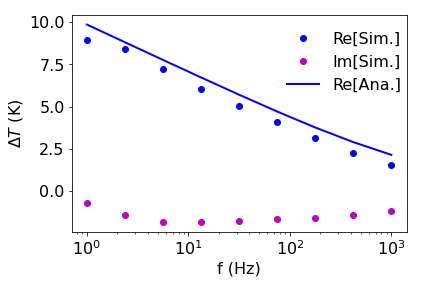

In [9]:
fig,ax=plt.subplots(1,1,figsize=[6,4])
ax.semilogx(freqs,Ts_real,'.',markersize=12,color='b',label='Re[Sim.]')
ax.semilogx(freqs,Ts_imag,'.',markersize=12,color='m',label='Im[Sim.]')    

ax.semilogx(freqs,integral,linewidth=2,label='Re[Ana.]',color='b')

ax.set_ylabel('$\Delta T$ (K)')
ax.set_xlabel('f (Hz)')
fig.legend(frameon = False,loc = [0.65,0.65])

## Figure out thermal conductivity

Thermal conductivity = 1.313 W/m/K


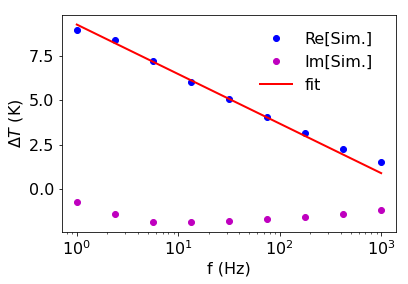

In [10]:
def log_fit(x,a,b):
    return a*np.log(x)+b

popt,pcov = curve_fit(log_fit,freqs[2:6],Ts_real[2:6])

print('Thermal conductivity = {:0.3f} W/m/K'.format(-P/np.pi/popt[0]/2))

fig,ax=plt.subplots(1,1,figsize=[6,4])
ax.semilogx(freqs,Ts_real,'.',markersize=12,color='b',label='Re[Sim.]')
ax.semilogx(freqs,Ts_imag,'.',markersize=12,color='m',label='Im[Sim.]')    

ax.semilogx(freqs,log_fit(np.array(freqs),*popt), linewidth = 2, alpha = 1, color='r',label = 'fit')

ax.set_ylabel('$\Delta T$ (K)')
ax.set_xlabel('f (Hz)')
fig.legend(frameon = False,loc = [0.62,0.65])